# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:

    - качество предсказания;
    - время обучения модели;
    - время предсказания модели.

## Описание данных

**Признаки**

    - DateCrawled — дата скачивания анкеты из базы
    - VehicleType — тип автомобильного кузова
    - RegistrationYear — год регистрации автомобиля
    - Gearbox — тип коробки передач
    - Power — мощность (л. с.)
    - Model — модель автомобиля
    - Kilometer — пробег (км)
    - RegistrationMonth — месяц регистрации автомобиля
    - FuelType — тип топлива
    - Brand — марка автомобиля
    - Repaired — была машина в ремонте или нет
    - DateCreated — дата создания анкеты
    - NumberOfPictures — количество фотографий автомобиля
    - PostalCode — почтовый индекс владельца анкеты (пользователя)
    - LastSeen — дата последней активности пользователя
    
**Целевой признак**

    - Price — цена (евро)

## Импортируем библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Модели

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split, KFold


from sklearn.metrics import f1_score, roc_auc_score, mean_squared_error, mean_absolute_error, make_scorer


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams, rcParamsDefault
from sklearn.model_selection import GridSearchCV
import numpy as np
import itertools 
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from functools import reduce   
from scipy import stats as st

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn import linear_model
from feature_engine.selection import DropCorrelatedFeatures, DropDuplicateFeatures

from sklearn.pipeline import Pipeline, FeatureUnion, FunctionTransformer
from imblearn.pipeline import make_pipeline
from numpy.random import RandomState
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import LabelEncoder

## Изучение данных

In [2]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')


In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


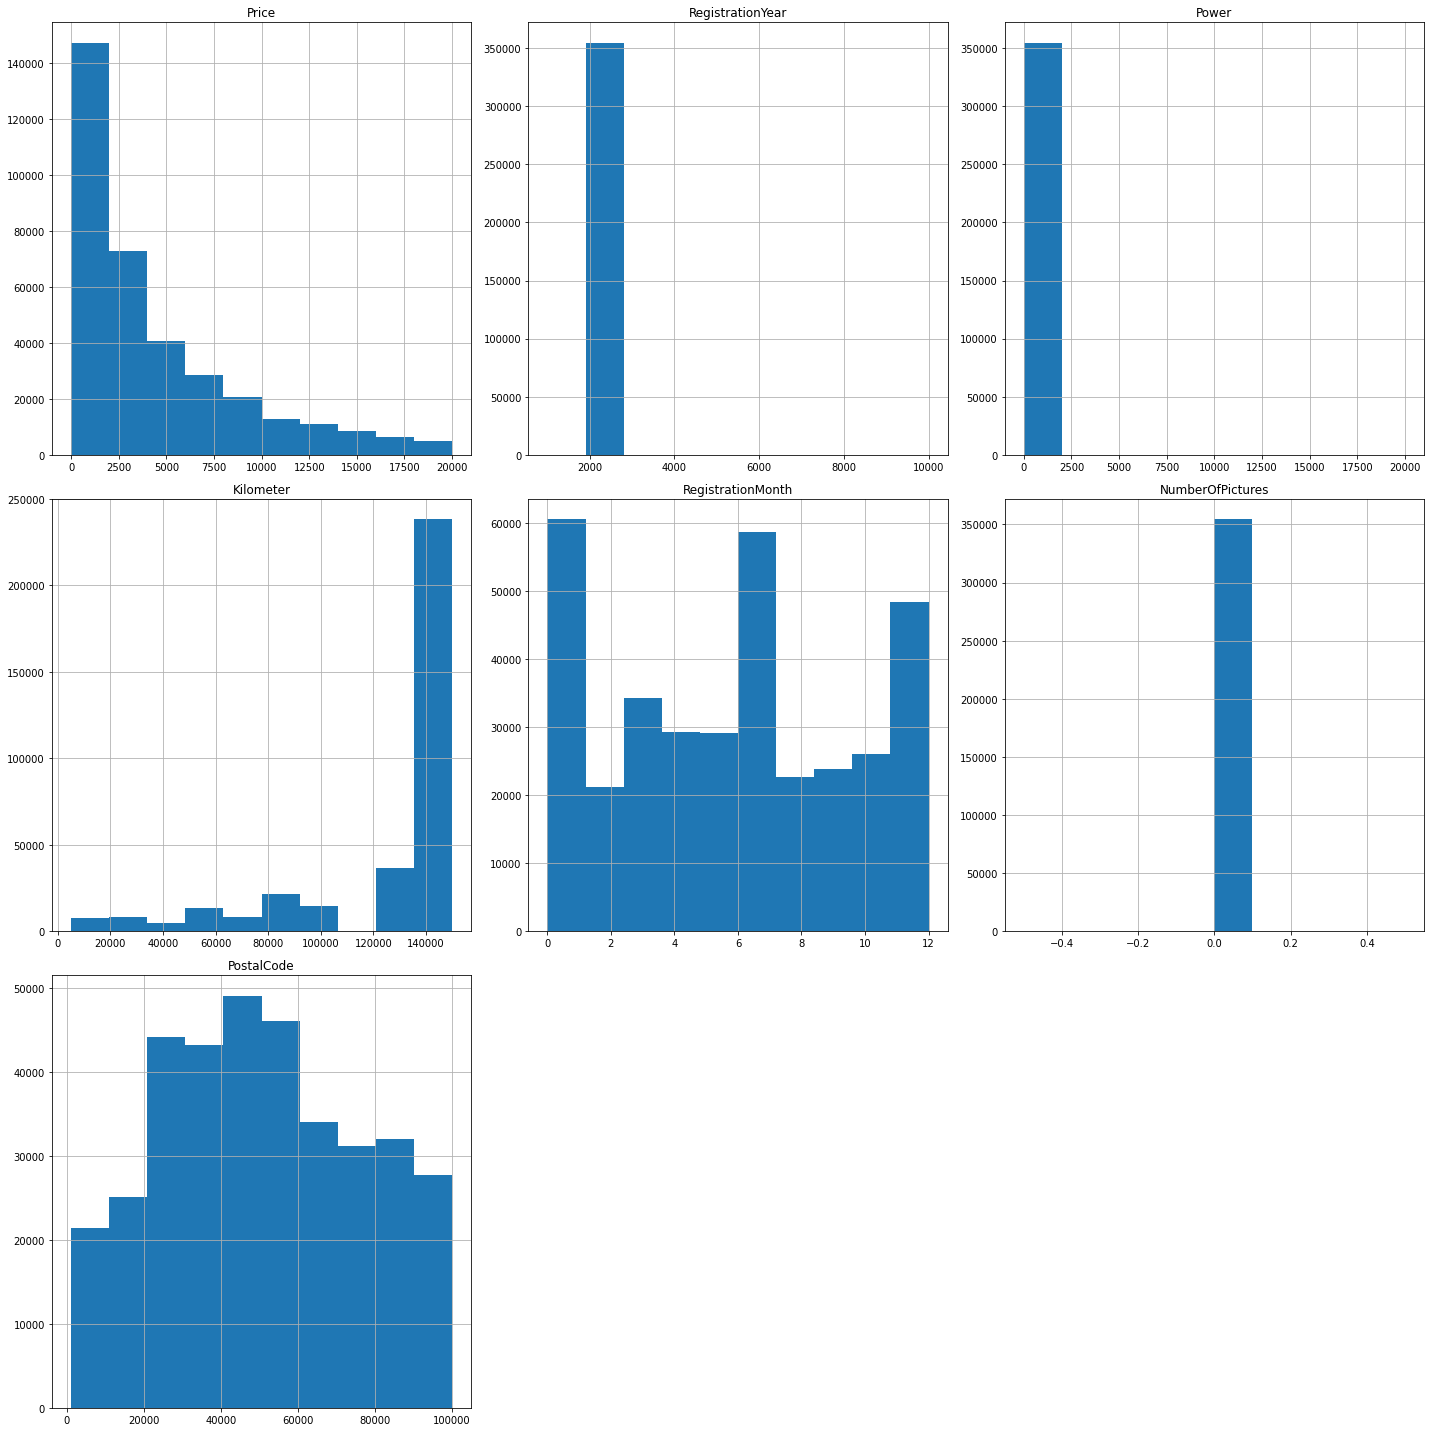

In [6]:
data.hist(figsize=(20, 20))
plt.tight_layout() 

**Выводы**

- Необходимо удалить неинформативные признаки
- Обработать данные
- Обучить модели

## Подготовка данных 

### Удалим признаки DateCreated, NumberOfPictures, PostalCode, LastSeen, RegistrationMonth

Удалим признаки DateCreated, NumberOfPictures, PostalCode, LastSeen, RegistrationMonth, как неинформативные.

In [7]:
data = data.drop(['DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationMonth'], axis=1)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   DateCrawled       354369 non-null  object
 1   Price             354369 non-null  int64 
 2   VehicleType       316879 non-null  object
 3   RegistrationYear  354369 non-null  int64 
 4   Gearbox           334536 non-null  object
 5   Power             354369 non-null  int64 
 6   Model             334664 non-null  object
 7   Kilometer         354369 non-null  int64 
 8   FuelType          321474 non-null  object
 9   Brand             354369 non-null  object
 10  Repaired          283215 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.7+ MB


Временно оставим DateCrawled для идентификации явных дубликатов

### Проверим явные дубликаты

In [9]:
data.duplicated().sum() 

25

In [10]:
data = data.drop_duplicates() ## Удалим явные дубликаты

In [11]:
data.duplicated().sum()

0

### Удалим DateCrawled

In [12]:
data = data.drop(['DateCrawled'], axis=1)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354344 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354344 non-null  int64 
 1   VehicleType       316854 non-null  object
 2   RegistrationYear  354344 non-null  int64 
 3   Gearbox           334511 non-null  object
 4   Power             354344 non-null  int64 
 5   Model             334639 non-null  object
 6   Kilometer         354344 non-null  int64 
 7   FuelType          321449 non-null  object
 8   Brand             354344 non-null  object
 9   Repaired          283190 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


### Стиль заголовков

In [14]:
data.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [15]:
data = data.rename(columns=str.lower)

In [16]:
data.columns

Index(['price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model',
       'kilometer', 'fueltype', 'brand', 'repaired'],
      dtype='object')

In [17]:
data = data.rename(columns={'vehicletype' : 'vehicle_type', 'registrationyear' : 'registration_year', 
                            'fueltype' : 'fuel_type'})

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354344 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354344 non-null  int64 
 1   vehicle_type       316854 non-null  object
 2   registration_year  354344 non-null  int64 
 3   gearbox            334511 non-null  object
 4   power              354344 non-null  int64 
 5   model              334639 non-null  object
 6   kilometer          354344 non-null  int64 
 7   fuel_type          321449 non-null  object
 8   brand              354344 non-null  object
 9   repaired           283190 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


### Обработаем пропуски

In [19]:
data.isnull().sum()

price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64

#### Процент пропусков

In [20]:
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

price - 0%
vehicle_type - 11%
registration_year - 0%
gearbox - 6%
power - 0%
model - 6%
kilometer - 0%
fuel_type - 9%
brand - 0%
repaired - 20%


#### Обработаем пропуски в vehicle_type

In [21]:
data['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [22]:
data['vehicle_type'] = data['vehicle_type'].fillna('other') # заполним пропуски значением 'other'

In [23]:
data.isnull().sum()

price                    0
vehicle_type             0
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64

#### Обработаем пропуски в gearbox

In [24]:
data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [25]:
data['gearbox'] = data['gearbox'].fillna('n/a') # заполним пропуски значением 'n/a'

In [26]:
data.isnull().sum()

price                    0
vehicle_type             0
registration_year        0
gearbox                  0
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64

#### Обработаем пропуски в model

In [27]:
data['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [28]:
data['model'] = data['model'].fillna('n/a') # заполним пропуски значением 'n/a'

In [29]:
data.isnull().sum()

price                    0
vehicle_type             0
registration_year        0
gearbox                  0
power                    0
model                    0
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64

#### Обработаем пропуски в fuel_type 

In [30]:
data['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [31]:
data['fuel_type'] = data['fuel_type'].fillna('other') # заполним пропуски значением 'other'

In [32]:
data.isnull().sum()

price                    0
vehicle_type             0
registration_year        0
gearbox                  0
power                    0
model                    0
kilometer                0
fuel_type                0
brand                    0
repaired             71154
dtype: int64

#### Обработаем пропуски в repaired  

In [33]:
data['repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [34]:
data['repaired'] = data['repaired'].fillna('no') # заполним пропуски значением 'no'

In [35]:
data.isnull().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

### Обработаем выбросы

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354344 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354344 non-null  int64 
 1   vehicle_type       354344 non-null  object
 2   registration_year  354344 non-null  int64 
 3   gearbox            354344 non-null  object
 4   power              354344 non-null  int64 
 5   model              354344 non-null  object
 6   kilometer          354344 non-null  int64 
 7   fuel_type          354344 non-null  object
 8   brand              354344 non-null  object
 9   repaired           354344 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


#### Обработаем price

In [37]:
data['price'].describe()

count    354344.000000
mean       4416.561477
std        4514.167328
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

<AxesSubplot:>

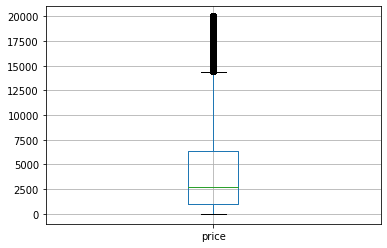

In [38]:
data.boxplot(column=['price'])

In [39]:
data[data['price'] < 10]['price'].count()

12028

In [40]:
data[data['price'] == 0]['price'].count()

10772

Предлагаю не удалять записи с аномально низкими ценами. Их достаточно много на мой взгляд.

#### Обработаем registration_year

In [41]:
data['registration_year'].describe()

count    354344.000000
mean       2004.234563
std          90.231117
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

<AxesSubplot:>

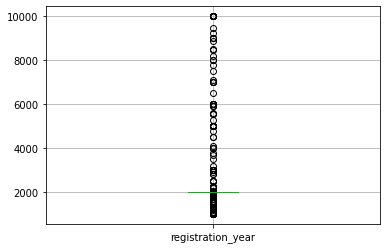

In [42]:
data.boxplot(column=['registration_year'])

In [43]:
data[data['registration_year'] < 1900]['registration_year'].count()

66

In [44]:
data = data.drop(data[data['registration_year'] < 1900].index)

In [45]:
data[data['registration_year'] > 2023]['registration_year'].count()

105

In [46]:
data = data.drop(data[data['registration_year'] > 2016].index)

#### Обработаем power

In [47]:
data['power'].describe()

count    339748.000000
mean        110.999664
std         186.884940
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

<AxesSubplot:>

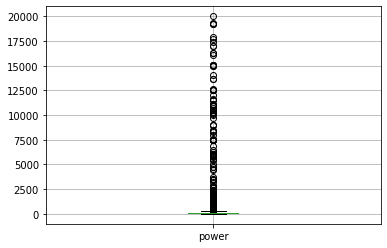

In [48]:
data.boxplot(column=['power'])

In [49]:
data[data['power'] > 1000]['power'].count()

277

In [50]:
data = data.drop(data[data['power'] > 1000].index)

#### Обработаем kilometer

In [51]:
data['kilometer'].describe()

count    339471.000000
mean     128088.187209
std       37889.291755
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

<AxesSubplot:>

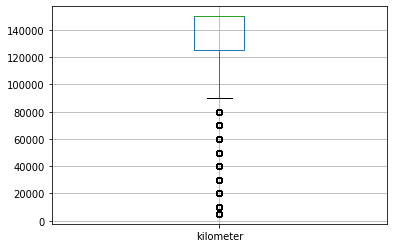

In [52]:
data.boxplot(column=['kilometer'])

Оставим признак без изменений

#### Конвертируем object в category 

In [53]:
obj_feat = list(data.loc[:, data.dtypes == 'object'].columns.values)
obj_feat

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [54]:
for feature in obj_feat:
    data[feature] = pd.Series(data[feature], dtype="category")

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339471 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              339471 non-null  int64   
 1   vehicle_type       339471 non-null  category
 2   registration_year  339471 non-null  int64   
 3   gearbox            339471 non-null  category
 4   power              339471 non-null  int64   
 5   model              339471 non-null  category
 6   kilometer          339471 non-null  int64   
 7   fuel_type          339471 non-null  category
 8   brand              339471 non-null  category
 9   repaired           339471 non-null  category
dtypes: category(6), int64(4)
memory usage: 15.2 MB


### Построение моделей

#### Подготовка выборок

In [56]:
features = data.drop(['price'], axis=1)
target = data['price']

features_train, features_test_valid, target_train, target_test_valid = train_test_split(features,target, 
                                                                            test_size=0.4, random_state=42)

features_valid, features_test, target_valid, target_test = train_test_split(features_test_valid,target_test_valid, 
                                                                            test_size=0.5, random_state=42)

print('Размер обучающей выборки: {} объектов, {} признаков'.format(features_train.shape[0], features_train.shape[1]))
print('Размер валидационной выборки: {} объектов, {} признаков'.format(features_valid.shape[0], features_valid.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(features_test.shape[0], features_test.shape[1]))


Размер обучающей выборки: 203682 объектов, 9 признаков
Размер валидационной выборки: 67894 объектов, 9 признаков
Размер тестовой выборки: 67895 объектов, 9 признаков


#### Отмасштабируем параметры

In [57]:
scaler = StandardScaler()
numeric = ['registration_year', 'power','kilometer']
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [58]:
features_train.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
253774,sedan,0.073261,manual,1.818384,impreza,0.578678,petrol,subaru,yes
160815,small,-0.349509,manual,-1.684356,twingo,0.578678,other,renault,no
270071,bus,1.341572,manual,0.051376,other,-0.082354,gasoline,peugeot,no
195536,other,0.355108,manual,-1.684356,ka,-1.272213,petrol,ford,no
247953,wagon,1.059725,auto,0.973973,superb,0.578678,gasoline,skoda,no


In [59]:
features_valid.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
322783,bus,0.636955,manual,-0.277005,other,0.578678,gasoline,fiat,no
201675,wagon,0.214184,manual,-0.277005,astra,0.578678,petrol,opel,no
157023,small,-0.349509,manual,-0.511564,polo,0.578678,petrol,volkswagen,yes
227224,wagon,-1.195050,manual,-1.684356,astra,0.578678,petrol,opel,no
331410,wagon,0.073261,manual,0.270298,mondeo,0.578678,petrol,ford,no


In [60]:
features_test.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
317725,sedan,-0.772279,auto,-0.104996,astra,0.578678,petrol,opel,no
16399,small,-0.067662,manual,-0.746122,2_reihe,0.578678,petrol,peugeot,no
109761,sedan,1.623419,manual,0.504856,leon,-1.801039,petrol,seat,no
197793,sedan,-0.490433,auto,-1.684356,n/a,-0.082354,petrol,jaguar,yes
149028,small,0.073261,manual,-0.839946,polo,0.578678,petrol,volkswagen,no


#### LightGBM

In [61]:
cat = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [62]:
light_gbm = LGBMRegressor(task='train', 
                        boosting_type='gbdt', 
                        objective='regression', 
                        metric='rmse', 
                        learning_rate=0.5, 
                        verbose=200,
                        categorical_feature=cat)

In [63]:
%%time
light_gbm.fit(features_train, target_train, eval_metric='rmse', 
              categorical_feature = cat, )

[LightGBM] [Warning] categorical_feature is set=vehicle_type,gearbox,model,fuel_type,brand,repaired, categorical_column=0,2,4,6,7,8 will be ignored. Current value: categorical_feature=vehicle_type,gearbox,model,fuel_type,brand,repaired
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.828300
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.194561
[LightGBM] [Debug] init for col-wise cost 0.004182 seconds, init for row-wise cost 0.005981 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data points in the train set: 203682, number of used features: 9
[LightGBM] [Info] Start training from score 4473.910537
[LightGBM] [Debug] Trained a tree with leaves = 31 

LGBMRegressor(categorical_feature=['vehicle_type', 'gearbox', 'model',
                                   'fuel_type', 'brand', 'repaired'],
              learning_rate=0.5, metric='rmse', objective='regression',
              task='train', verbose=200)

In [64]:
%%time
gbm_preds = light_gbm.predict(features_valid)

CPU times: user 314 ms, sys: 2.7 ms, total: 317 ms
Wall time: 93 ms


In [65]:
gbm_rmse = mean_squared_error(target_valid, gbm_preds, squared=False)
gbm_rmse

1747.09832977994

#### Catboost

In [66]:
catboost = CatBoostRegressor(loss_function='RMSE', 
                              iterations=250, 
                              learning_rate=0.2, 
                              thread_count=-1, 
                              random_state=42, 
                              max_depth=10, 
                              l2_leaf_reg=3.5,
                              cat_features=cat
                              )

In [67]:
%%time
catboost.fit(features_train, target_train,
              verbose=200)

0:	learn: 3912.1635121	total: 199ms	remaining: 49.4s
200:	learn: 1560.2771970	total: 23.5s	remaining: 5.73s
249:	learn: 1530.2756829	total: 29.2s	remaining: 0us
CPU times: user 1min 47s, sys: 888 ms, total: 1min 48s
Wall time: 29.7 s


In [68]:
%%time
cat_preds = catboost.predict(features_valid)

CPU times: user 280 ms, sys: 16.5 ms, total: 296 ms
Wall time: 97.4 ms


In [69]:
cat_rmse = mean_squared_error(target_valid, cat_preds, squared=False)
cat_rmse

1711.0068347244294

#### LinearRegression

##### Создадим выборки

In [70]:
features_lin = data.drop(['price'], axis=1)
target_lin = data['price']

features_train_lin, features_test_lin, target_train_lin, target_test_lin = train_test_split(features_lin,target_lin, 
                                                                            test_size=0.4, random_state=42)

print('Размер обучающей выборки: {} объектов, {} признаков'.format(features_train_lin.shape[0], features_train_lin.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(features_test_lin.shape[0], features_test_lin.shape[1]))

Размер обучающей выборки: 203682 объектов, 9 признаков
Размер тестовой выборки: 135789 объектов, 9 признаков


##### Конвертируем категориальные признаки

In [71]:
features_train_ohe = pd.get_dummies(features_train_lin, columns=cat, drop_first=True)
features_train_ohe.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 203682 entries, 253774 to 127163
Columns: 308 entries, registration_year to repaired_yes
dtypes: int64(3), uint8(305)
memory usage: 65.5 MB


In [72]:
features_test_ohe = pd.get_dummies(features_test_lin, columns=cat, drop_first=True)
features_test_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135789 entries, 123924 to 46197
Columns: 308 entries, registration_year to repaired_yes
dtypes: int64(3), uint8(305)
memory usage: 43.6 MB


##### Обучим модель

In [73]:
linreg = LinearRegression()

In [74]:
%%time
params = {
          'fit_intercept': [True, False],
           'copy_X': [True, False]
    
          
            }

grid_model_regr = GridSearchCV(linreg, params, cv=3,
                          scoring='neg_mean_absolute_error', n_jobs=-1)

grid_model_regr.fit(features_train_ohe, target_train)

CPU times: user 19.8 s, sys: 619 ms, total: 20.4 s
Wall time: 1min 29s


GridSearchCV(cv=3, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False]},
             scoring='neg_mean_absolute_error')

In [75]:
%%time
linreg_preds = grid_model_regr.predict(features_train_ohe)

CPU times: user 266 ms, sys: 79.7 ms, total: 346 ms
Wall time: 346 ms


In [76]:
linreg_rmse = mean_squared_error(target_train, linreg_preds, squared=False)
linreg_rmse

2802.0084177584968

### Анализ моделей

В ходе выполнения задачи нами были выполнены следующие задачи:
- Были предобработаны масштабированы и конвертированны для удобства обучения данные. Заполнены пропуски , удалены дубликаты и аномалии.
- Обучены три модели: LightGBM, CatBoost, LinearRegression.
- Получены интересующие нас метрики.

In [77]:
info = pd.DataFrame(data=[['RMSE', 1747.09832977994, 1711.0068347244294,2802.0084177584968 ], 
                          ['Fit Time', '451 ms', '28.3 s', '1min 17s'], 
                          ['Prediction Time', '100 ms', '113 ms', '304 ms']], 
                    columns=['Category', 'LightGBM', 'CatBoost', ' LinearRegression'] ) 
info

,Category,LightGBM,CatBoost,LinearRegression
0,RMSE,1747.09833,1711.006835,2802.008418
1,Fit Time,451 ms,28.3 s,1min 17s
2,Prediction Time,100 ms,113 ms,304 ms


Из полученых данных видно, что хотя значения RMSE у моделей LightGBM и CatBoost сравнимы LightGBM работает быстрее. Поэтому я рекомендую использовать LightGBM 

### Тестирование лучшей модели

In [78]:
gbm_preds_test =  light_gbm.predict(features_test)
gbm_rmse_test = mean_squared_error(target_test, gbm_preds_test, squared=False)
gbm_rmse_test

1730.5942339705368

### Общий вывод 

В ходе выполнения задачи нами были выполнены следующие задачи:
- Были предобработаны масштабированы и конвертированны для удобства обучения данные. Заполнены пропуски , удалены дубликаты и аномалии.
- Обучены три модели: LightGBM, CatBoost, LinearRegression.
- Получены интересующие нас метрики.

In [79]:
info = pd.DataFrame(data=[['RMSE', 1747.09832977994, 1711.0068347244294,2802.0084177584968 ], 
                          ['Fit Time', '451 ms', '28.3 s', '1min 17s'], 
                          ['Prediction Time', '100 ms', '113 ms', '304 ms']], 
                    columns=['Category', 'LightGBM', 'CatBoost', ' LinearRegression'] ) 
info

,Category,LightGBM,CatBoost,LinearRegression
0,RMSE,1747.09833,1711.006835,2802.008418
1,Fit Time,451 ms,28.3 s,1min 17s
2,Prediction Time,100 ms,113 ms,304 ms


RMSE LightGBM на тестовой выборке 1730.5942339705368